# <center> 2017 机器学习第三次作业</center>
| 姓名    |    分工   | 工作量 |
|--------|-------------|------|
| 张尉东  | 任务1,2      |33.33%|
| 王海燕  | 任务1,2      |33.33%|
| 张明悦  | 任务1,2      |33.33%|

## 1. 概念定义及数据预处理

### (a.) 概念定义:    
- **活跃作者**: 我们将2007至2017年分为三段```[2007, 2011), [2011, 2015), [2015, 2018)```, 并将活跃作者定义为三个阶段都出现的作者;
- **团队**: 经常性在一起合作的学者称之为**团队**;
- **频繁团队**: 至少一起发表过3篇以上论文的团队称之为**频繁团队**.

### (b.) 数据结构定义:
定义类型```class Article```, 将数据读入内存并存放在数组```articles```中, 代码如下:

In [2]:
class Article:
    def __init__(self, str):
        self.authors = []
        lines = str.split('\n')
        for line in lines:
            if line is '' or line is None or line == "":
                continue
            key, value = line.split('\t', 1)
            if key == 'author':
                self.authors.append(value)
            elif key == 'title':
                self.title = value
            elif key == 'year':
                self.year = int(value)
            elif key == 'Conference':
                self.conference = value
    
    def display(self):
        str = ' '.join(self.authors) + ':' + self.title + ',' + self.conference
        print(str)
    
    
def parse_article(filename):
    fin = open(filename)
    content = fin.read()
    blocks = content.split('#########')
    articles = []
    for block in blocks:
        if block is '' or block is None or block == "":
            continue
        art = Article(block)
        # art.display()
        articles.append(art)
    return articles
        
articles = parse_article('data/FilteredDBLP.txt')

## 2. 活跃作者挖掘
(**任务1.1**: 根据时间信息，判定哪些人依然活跃，哪些人不再活跃。)

### (a.) ***活跃作者***挖掘及存储
我们将挖掘出的活跃作者存储在一个```active_authors_years = dict()```结构体中, 其结构为:
```python
{'authorname':[year1, year2, ...]}
```

### (b.) 结果展示
- ***活跃作者***: 如表2.1所以, 我们列出了部分活跃作者;
- ***作者的活跃程度***: 如图2.1所示的散列图, 表示越活跃的作者(出现次数越多), 散列点越大;
- ***连续活跃程度***: 如图2.2所示的活动轨迹图, 我们将活跃的作者(至少出现5次以上)依据其出现的年份连成一条活跃年份图.

                                  表2.1 活跃作者及活跃年份                   
The number of active author: 1326
Index    Author Name                         Years     
-----    -------------                       --------- 
0        Fatih Murat Porikli                 {2008, 2014, 2015}
1        Lars Schmidt-Thieme                 {2009, 2011, 2012, 2014, 2015}
2        W. Bruce Croft                      {2016, 2017, 2007, 2008,...
3        Hankz Hankui Zhuo                   {2017, 2009, 2011, 2012,...
4        Kilian Q. Weinberger                {2016, 2017, 2008, 2010,...
5        Chang Huang                         {2016, 2009, 2010, 2011,...
6        Vernon Asuncion                     {2017, 2010, 2012, 2014}
7        Yizhou Sun                          {2016, 2017, 2009, 2010,...
8        Arnold W. M. Smeulders              {2016, 2017, 2007, 2008,...
9        Derek Hoiem                         {2016, 2007, 2008, 2009,...
10       Francesco Bonchi                    {2016, 2008, 2010, 2

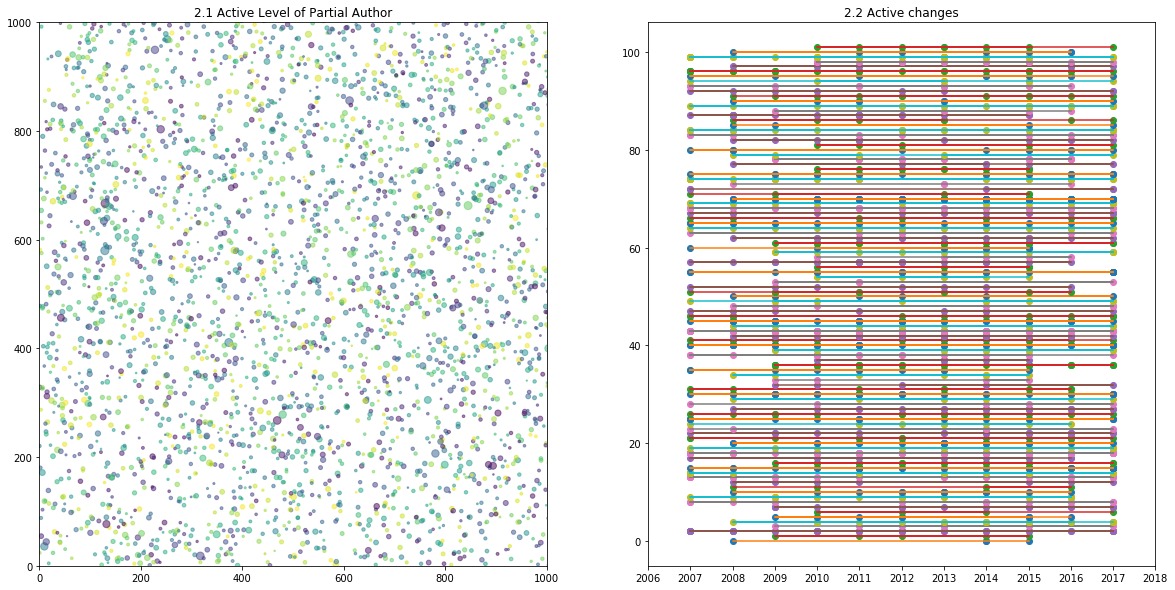

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# Fixing random state for reproducibility
np.random.seed(19680801)

def find_active_author(articles):
    # Statistics the number of author occurences and years
    author_years = dict()
    for article in articles:
        for author in article.authors:
            if author in author_years:
                author_years[author].append(article.year)
            else:
                author_years[author] = [article.year]
    active_author_years = dict()
    for idx, kv in enumerate(author_years.items()):
        key, value = kv
        if len(value) > 3 and min(value) in range(2007, 2011) and max(value) in range(2015, 2018) and np.median(value) in range(2011, 2015):
            active_author_years[key] = value
    return active_author_years

def display_active_authors(active_author_years, num):
    print("{:<33} {:<33}".format('', '表2.1 活跃作者及活跃年份'))
    print('The number of active author:',len(active_author_years))
    # formatly output the active auth, only output 50 items
    print("{:<8} {:<35} {:<10}".format('Index','Author Name','Years'))
    print("{:<8} {:<35} {:<10}".format('-----','-------------','---------'))
    for idx, kv in enumerate(active_author_years.items()):
        key, value = kv
        print("{:<8} {:<35} {:<10}".format(idx, key, textwrap.shorten(str(set(value)), width=30, placeholder='...')))
        if idx > num:
            print('... ...')
            break

# 1. display the active authors and their active years
active_author_years = find_active_author(articles)
display_active_authors(active_author_years, 30)

# 2. plot the ative level  
fig1 = plt.figure(figsize=(20,10))
def plot_active_level(active_author_years):
    N = len(articles)
    x = np.random.rand(N) * 3000
    y = np.random.rand(N) * 3000
    colors = np.random.rand(N)
    area = np.pi * (15 * np.array([len(years)/100.0 for years in active_author_years.keys()]))**2  # 0 to 15 point radii

    ax1 = fig1.add_subplot(121)
    # ax1.xlim(0, 500)
    ax1.set_xlim([0, 1000])
    ax1.set_ylim([0, 1000])
    ax1.scatter(x, y, s=area, c=colors, alpha=0.5)
    ax1.set_title('2.1 Active Level of Partial Author')
    ax1.legend(numpoints=1, loc='upper left')

# 3. plot the ative changes  
def plot_active_changes(active_author_years, num):
    ax2 = fig1.add_subplot(122)
    ax2.set_title('2.2 Active changes')
    ax2.set_xlim([2006, 2018])
    years = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
    ax2.set_xticks(years)
    
    for idx, active_author_years in enumerate(active_author_years.items()):
        author, years = active_author_years
        ax2.plot(years, np.ones(len(years)) * idx, 'o', years, np.ones(len(years)) * idx, '-')
        if (idx > num):
            break

plot_active_level(active_author_years)
plot_active_changes(active_author_years, 100)
plt.show()

## 3. 频繁项挖掘
(**任务1.2**: 经常性在一起合作的 学者，将之称为‘团队’, 根据研究者合作发表论文次数为根据 进行频繁模式挖掘，找出三个人以上的‘团队’.)

### (a.) 找出支持度support>=5的所有学者

In [4]:
from pymining import itemmining
# transactions = (('a', 'b', 'c'), ('b'), ('a'), ('a', 'c', 'd'), ('b', 'c'), ('b', 'c'))
# relim_input = itemmining.get_relim_input(transactions)
# report = itemmining.relim(relim_input, min_support=2)
def display_active_teams(active_teams, minimum_author, records):
    print("{:<33} {:<33}".format('', '表3.1 人数>=1, 合作次数>=5的团队'))
    print('The number of active teams:',len(active_teams))
    # formatly output the active auth, only output 50 items
    print("{:<8} {:<35}".format('Index','Author Name'))
    print("{:<8} {:<35}".format('-----','-------------','---------'))
    counter = 0
    for idx,authors in enumerate(active_teams):
        if len(authors) >= minimum_author:  
            print("{:<8} {:<35}".format(counter, ', '.join(authors)))
            counter += 1
        if counter > records:
            print('... ...')
            break

authors = [article.authors for article in articles]
relim_input = itemmining.get_relim_input(authors)
report = itemmining.relim(relim_input, min_support=5)
display_active_teams(report, 1, 10)

                                  表3.1 人数>=1, 合作次数>=5的团队           
The number of active teams: 5985
Index    Author Name                        
-----    -------------                      
0        Ming Yang                          
1        Supun Samarasekera                 
2        Fei-Fei Li, Vignesh Ramanathan     
3        XuanLong Nguyen                    
4        Kun Zhou                           
5        Neil D. Lawrence                   
6        Jörg H. Kappes                     
7        Shireen Y. Elhabian                
8        Subhransu Maji                     
9        Yoram Bachrach, Yoad Lewenberg     
10       Sang-Wook Kim                      
... ...


### (b.) 找出合作者个数>=3的所有合作团队

In [34]:
display_active_teams(report, 3, 10)

                                  表3.2 人数>=3, 合作次数>=5的团队           
The number of active teams: 5985
Index    Author Name                        
-----    -------------                      
0        Furu Wei, Ming Zhou 0001, Li Dong  
1        Jun Xu, Jiafeng Guo, Xueqi Cheng, Yanyan Lan
2        Horst Bischof, Amir Saffari, Christian Leistner
3        Jiawei Han 0001, Chao Zhang, Quan Yuan
4        Kate Saenko, Trevor Darrell, Marcus Rohrbach
5        Xiaoqian Wang, Feiping Nie, Heng Huang
6        Justin Zobel, Alistair Moffat, William Webber
7        Michael R. Lyu, Haiqin Yang, Irwin King
8        Kuldeep S. Meel, Supratik Chakraborty, Moshe Y. Vardi
9        Min Zhang, Shaoping Ma, Yiqun Liu  
10       Shiqiang Yang, Peng Cui, Fei Wang 0001
... ...


## 4. 主题挖掘
(**任务2.1**: 先定出主题词， 然后根据每个‘团队’发表的论文的情况，提炼出这个团队最常涉猎的主题。)

### (a.) 根据Latent Dirichlet allocation(LDA)主题模型训练出所有的模型:
我们将主题数设置为20, 经过LDA模型聚类, 我们得到了如表4.1所示的模型, 及其代表性的词.

In [56]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

def train_ldamodel(articles):
    tokenizer = RegexpTokenizer(r'\w+')

    # create English stop words list
    en_stop = get_stop_words('en')

    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()

    # compile sample documents into a list
    titles = [article.title for article in articles]
    doc_set = []
    for title in titles:
        doc_set.append(title)

    # list for tokenized documents in loop
    texts = []

    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)

        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]

        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

        # add tokens to list
        texts.append(stemmed_tokens)

    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)

    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]

    # generate LDA model
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=20)
    return corpus, ldamodel

corpus, ldamodel = train_ldamodel(articles)

### (b.) 确定主题及主题词

In [54]:
# ldamodel = train_ldamodel(articles)
ldamodel.print_topics()
ldamodel.show_topic(10)
print("{:<33} {:<33}".format('', '表4.1 20个主题及主题下的关键词'))
for i in range(2):
    topic_terms1 = ldamodel.show_topic(i * 5)
    topic_terms2 = ldamodel.show_topic(i * 5 + 1)
    topic_terms3 = ldamodel.show_topic(i * 5 + 2)
    topic_terms4 = ldamodel.show_topic(i * 5 + 3)
    topic_terms5 = ldamodel.show_topic(i * 5 + 4)
    #print(topic_terms1)
    print("{:<20} {:<22} {:<20} {:<20} {:<22}".format('Topic-' + str(i * 5), 'Topic-' + str(i * 5 + 1), 'Topic-'+ str(i * 5 + 2), 'Topic-'+ str(i * 5 + 3), 'Topic-'+ str(i * 5 + 4)))
    print("{:<20} {:<22} {:<20} {:<20} {:<22}".format('----------','----------','----------','----------','----------'))
    print("{:<12} {:<8} {:<12} {:<8} {:<12} {:<8} {:<12} {:<8} {:<12} {:<8}".format('Term','Prob','Term','Prob','Term','Prob','Term','Prob','Term','Prob',))
    print("{:<12} {:<8} {:<12} {:<8} {:<12} {:<8} {:<12} {:<8} {:<12} {:<8}".format('-----','-----','-----','-----','-----','-----','-----','-----','-----','-----',))
    for term_prob1, term_prob2, term_prob3, term_prob4, term_prob5 in zip(topic_terms1, topic_terms2, topic_terms3, topic_terms4, topic_terms5):
        # term1, prob1 = term_prob1
        print("{:<12} {:<8} {:<12} {:<8} {:<12} {:<8} {:<12} {:<8} {:<12} {:<8}".format(term_prob1[0], "{0:.3f}".format(term_prob1[1]), term_prob2[0], "{0:.3f}".format(term_prob2[1]), term_prob3[0], "{0:.3f}".format(term_prob3[1]), term_prob4[0], "{0:.3f}".format(term_prob4[1]), term_prob5[0], "{0:.3f}".format(term_prob5[1])))
    if i== 0:
        print('\n')

                                  表4.1 20个主题及主题下的关键词               
Topic-0              Topic-1                Topic-2              Topic-3              Topic-4               
----------           ----------             ----------           ----------           ----------            
Term         Prob     Term         Prob     Term         Prob     Term         Prob     Term         Prob    
-----        -----    -----        -----    -----        -----    -----        -----    -----        -----   
logic        0.056    select       0.063    variat       0.030    map          0.042    structur     0.093   
program      0.045    camera       0.050    invari       0.028    data         0.037    shape        0.053   
linear       0.037    featur       0.049    dataset      0.022    measur       0.032    learn        0.040   
set          0.034    pose         0.043    level        0.022    consist      0.029    model        0.032   
dynam        0.032    recommend    0.034    theoret   

### (c.) 确定团队经常涉猎的主题
使用映射 `作者<--->标题<--->主题` 将作者经常所涉猎的主题进行关联:

In [76]:
topics = ldamodel.get_topics()
# print(ldamodel.show_topic(19, topn=3))
doc2topics = ldamodel.get_document_topics(corpus)
# print(len(doc2topics))
# print(doc2topics[0])
# print(doc2topics[1])
# len(doc2topics)

print("{:<25} {:<35}".format('', '表4.2 研究团队经常涉猎的主题及其主题下的关键词'))
print("{:<55} {:<22} {:<35}".format('Team memebers', 'Topic IDs', 'Topic Terms'))
print("{:<55} {:<22} {:<35}".format('--------------------','---------', '-----------------------'))
for idx, article in enumerate(articles[:10]):
    max_prob_topic = 0
    max_prob = 0.0
    # Find the topic_id with maximum probability
    topic_id_str = ""
    for topic_id, prob in doc2topics[idx]:
        topic_id_str += str(topic_id) + ","
        if prob > max_prob:
            max_prob = prob
            max_prob_topic = topic_id
    topic_terms = [topic_prob[0] for topic_prob in ldamodel.show_topic(max_prob_topic, topn=3)]
    print("{:<55} {:<22} {:<35}".format(textwrap.shorten(', '.join(article.authors), width=50, placeholder="..."), topic_id_str, ', '.join(topic_terms)))
    #str = ', '.join(article.authors) + "--->" + ', '.join(topic_terms)
    #print(str)

                          表4.2 研究团队经常涉猎的主题及其主题下的关键词          
Team memebers                                           Topic IDs              Topic Terms                        
--------------------                                    ---------              -----------------------            
Miroslaw Truszczynski, Stefan Woltran                   2,9,11,18,             recognit, face, languag            
Guibing Guo, Jie Zhang, Neil Yorke-Smith                3,8,14,15,17,          network, deep, neural              
Xinwang Liu, Yong Dou, Jianping Yin, Lei Wang...        10,14,17,18,           learn, decis, tree                 
Mickey Brautbar, Michael J. Kearns, Umar Syed           4,6,9,12,13,16,17,18,  logic, cluster, base               
Shirin Sohrabi, Anton V. Riabov, Octavian Udrea         2,6,16,18,             logic, cluster, base               
Maximilian Nickel, Lorenzo Rosasco, Tomaso A....        6,8,13,18,             featur, select, embed              
Kyle Lund, Sam Die

## 5. 团队和主题多是会随着时间而动态变化
(**任务2.2**: 根据自己所定的时间段(五年，三年，两年或是一年)描述团队的构成状况以及其研究主题的变化情况。)